1\. **2D minimization of a six-hump camelback function**

$$f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2$$

has multiple global and local minima.

- Find the global minima of this function
- How many global minima are there, and what is the function value at those points?
- What happens for an initial guess of $(x, y) = (0, 0)$?

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use `numpy.meshgrid()` and `pylab.imshow()` to find visually the regions.
* Use `scipy.optimize.minimize()`, optionally trying its optional arguments.


the minima of the function is: -1.031628446687356 found int the point:  [-0.08980028  0.71265668]

there are 3  global minima
for an initial guess of [0,0] the solutions slightly different


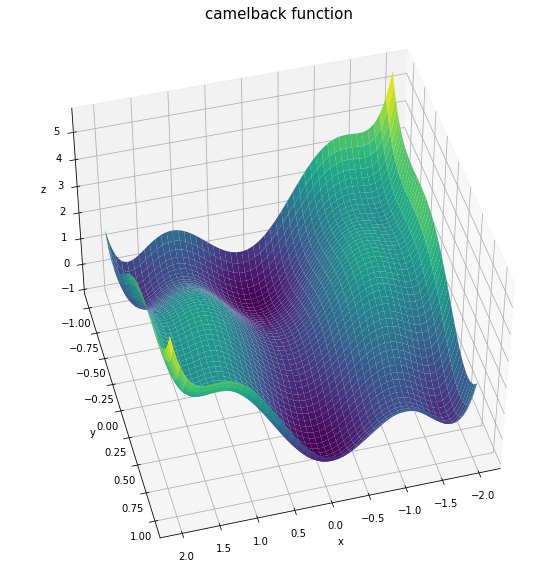

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.optimize import root, fsolve
from matplotlib import pylab
%matplotlib inline

def f(x):
    return ((4-2.1*x[0]**2+(x[0]**4)/3)*x[0]**2+x[0]*x[1]+(4*x[1]**2-4)*x[1]**2)

x0 = np.linspace(-2, 2, 100)
x1 = np.linspace(-1, 1, 100)

fig = plt.figure(figsize=(10,10))

ax = plt.axes(projection='3d')
X, Y = np.meshgrid(x0, x1)
Z = f([X, Y])
ax.plot_surface(X, Y, Z, cmap='viridis')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');
ax.set_title('camelback function', size=15)
ax.view_init(45, 75)
fig

solution = optimize.minimize(f,[-1, 1], args=(), method='Nelder-Mead', bounds=[[-2, 2],[-2, 2]])
#print(solution) 

print('\nthe minima of the function is:',solution['fun'], 'found int the point: ',solution['x'])
print('\nthere are',solution.final_simplex[0].shape[0],' global minima')

solution2 = optimize.minimize(f,[0, 0], args=(), method='Nelder-Mead', bounds=[[-2, 2],[-2, 2]])
#print(solution2)
print('for an initial guess of [0,0] the solutions slightly different')


2\. **Curve fitting of temperature in Alaska** 

The temperature extremes in Alaska for each month, starting in January, are given by (in degrees Celcius):

max:  `17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18`

min: `-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58`

* Plot these temperatures.
* Find a suitable a function that can describe min and max temperatures. 
* Fit this function to the data with `scipy.optimize.curve_fit()`.
* Plot the result. Is the fit reasonable? If not, why?
* Is the time offset for min and max temperatures the same within the fit accuracy?

the fit is quite good as it can be seen from the graph
the max temperature is achived in the : 5.73581555618863 -th month
the max (min) temperature is achived in the : 6.164525883020017 -th month


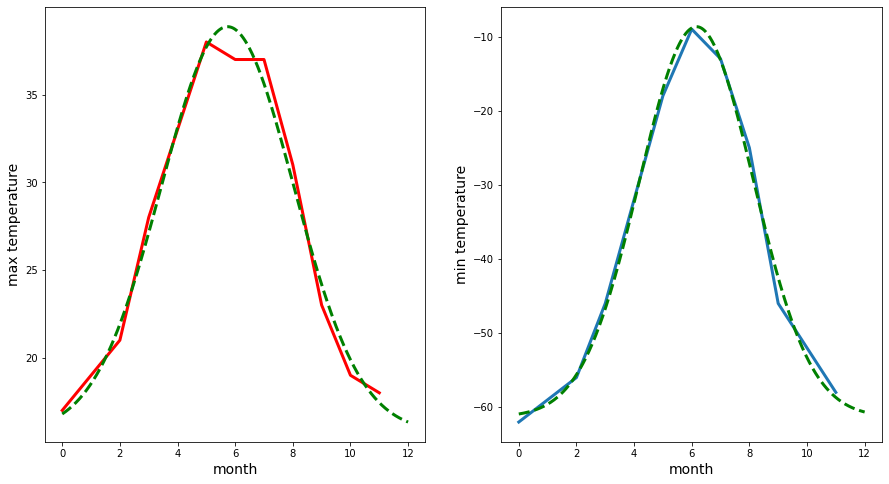

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import math
t_max=[ 17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18]
t_min=[-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58]

time=np.arange(12)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8))

ax1.plot(time,t_max, linewidth=3, markersize=5,  color='red')
ax2.plot(time,t_min, linewidth=3, markersize=5)
ax1.set_ylabel('max temperature', size=14)
ax2.set_ylabel('min temperature', size=14)
ax1.set_xlabel('month', size=14)
ax2.set_xlabel('month', size=14)


def f(time, fondo, ampl, mu,sigma):
    return (fondo + ampl * np.exp(-0.5* ((time-mu)/sigma)**2))     #similar to a gaussian but with a background (constant)

time_short=np.linspace(0, 12, 500)

res_max, cov_max = optimize.curve_fit(f, time, t_max, p0 = [6, 25, 4, 4])
res_min, cov_min = optimize.curve_fit(f, time, t_min, p0 = [-60, 25, 4, 4])

ax1.plot(time_short, f(time_short, *res_max), 'g--', linewidth=3)
ax2.plot(time_short, f(time_short, *res_min), 'g--', linewidth=3)


print('the fit is quite good as it can be seen from the graph')
print('the max temperature is achived in the :',res_max[2],'-th month')
print('the max (min) temperature is achived in the :',res_min[2],'-th month')

3\. **Fit the residues**

Read the `data/residuals_261.pkl` file. If you haven't it already, download it from here:

```bash
wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/
```

The feature name "residual" contains the residuals (defined as $y_i - \hat{y}_i$) of a linear regression as a function of the independent variable "distances".

- Considering only the "residual" feature, create an histogram with the appropriate binning and display it.
- Set the appropriate Poisson uncertainty for each bin (thus, for each bin, $\sigma_i = \sqrt{n_i}$, where $n_i$ is the number of entries in each bin)
- By looking at the distribution of the residuals, define an appropriate function and fit it to the histogram of the residuals
- Perform a goodness-of-fit test. Is the p-value of the fit satisfactory?

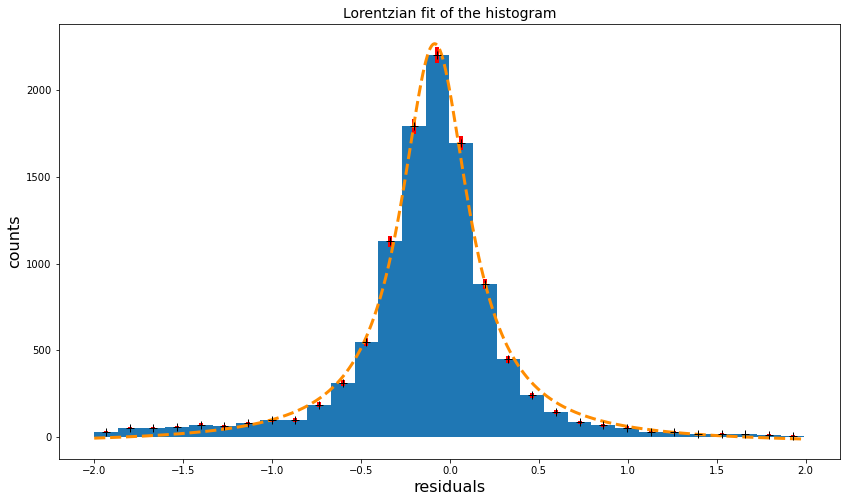

the chi-square obtained is:  432.9251930720057 with 29 degree of freedom
p-value = 0.0
the p-value smaller than 0.05 confirms that the fit is not satisfactory, nevertheless the fit seems quite good, specially in the right region the data predicted are not compatible with the experimental data


In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import numpy as np
from scipy import optimize
from scipy import stats
import scipy

fig = plt.figure(figsize=(14,8))
diz=dict(pd.read_pickle('residuals_261.pkl').item())
data=pd.DataFrame(diz)
data = data.loc[(data["residuals"] > -2) & (data["residuals"] < 2)]
res=data['residuals'].to_numpy()

M=30
y,bin_edges,_=plt.hist(res, M)

err_y=[]
bin_centers=np.zeros(M)
for i in range(len(y)):
    if y[i]!=0:
        err_y.append(np.sqrt(y[i])) 
    else:
        err_y.append(0)

for i in range(len(bin_edges)-1):
    bin_centers[i] = 0.5*(bin_edges[i] + bin_edges[i+1])


plt.errorbar(bin_centers, y, yerr=err_y, fmt="+k", ecolor='red', elinewidth=4, markersize=8)



def lorentzian( x, x0, a ,gamma, fondo):
    return (a * gamma / ( gamma**2 + ( x - x0 )**2))+fondo


time_short=np.linspace(min(res), max(res), 500)
plt.title('Lorentzian fit of the histogram', size=14)
res, cov = optimize.curve_fit(lorentzian, bin_centers, y, p0 = [-0.1, 2000, 0.3, 30])
plt.plot(time_short, lorentzian(time_short, *res), 'r--', linewidth=3, color='darkorange')
plt.xlabel('residuals', size=16)
plt.ylabel('counts',size=16)

plt.show()

y_predicted=lorentzian(bin_centers, *res)
dof=len(y)-1
chi_quadro=np.sum(((y_predicted-y)/err_y)**2)
print('the chi-square obtained is: ', chi_quadro, 'with',dof,'degree of freedom')

pvalue = 1. - scipy.stats.chi2.cdf(chi_quadro, dof)
print("p-value =", pvalue) 
print('the p-value smaller than 0.05 confirms that the fit is not satisfactory, nevertheless the fit seems quite good, specially in the right region the data predicted are not compatible with the experimental data') 

4\. **Temperatures in Munich**

Get the following data file:

```bash
https://www.dropbox.com/s/7gy9yjl00ymxb8h/munich_temperatures_average_with_bad_data.txt
```

which gives the temperature in Munich every day for several years.


Fit the following function to the data:

$$f(t) = a \cos(2\pi t + b)+c$$

where $t$ is the time in years.

- Make a plot of the data and the best-fit model in the range 2008 to 2012.

   - What are the best-fit values of the parameters?

   - What is the overall average temperature in Munich, and what are the typical daily average values predicted by the model for the coldest and hottest time of year?

   - What is the meaning of the $b$ parameter, and what physical sense does it have?


- Now fit the data with the function $g(x)$, which has 1 more parameter than $f(x)$.
$$g(x) = a \cos(2\pi b t + c)+d$$
   - What are the RSS for $f(x)$ and $g(x)$?
   - Use the Fisher F-test to determine whether the additional parameter is motivated.

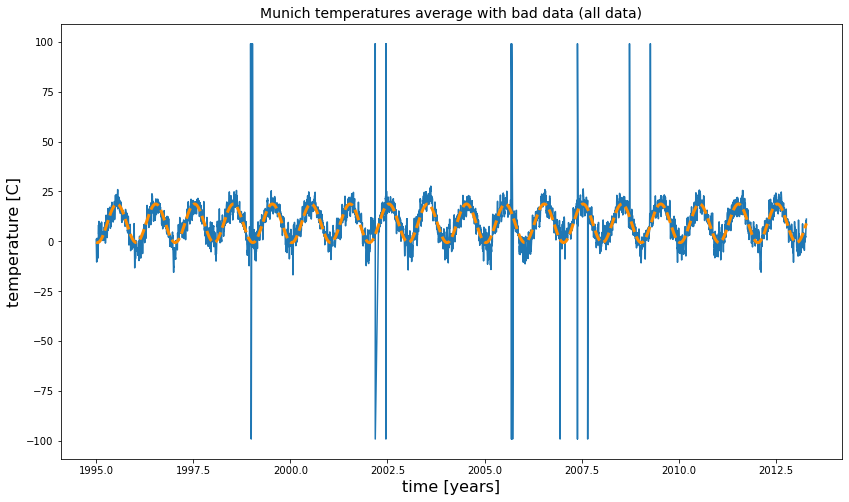

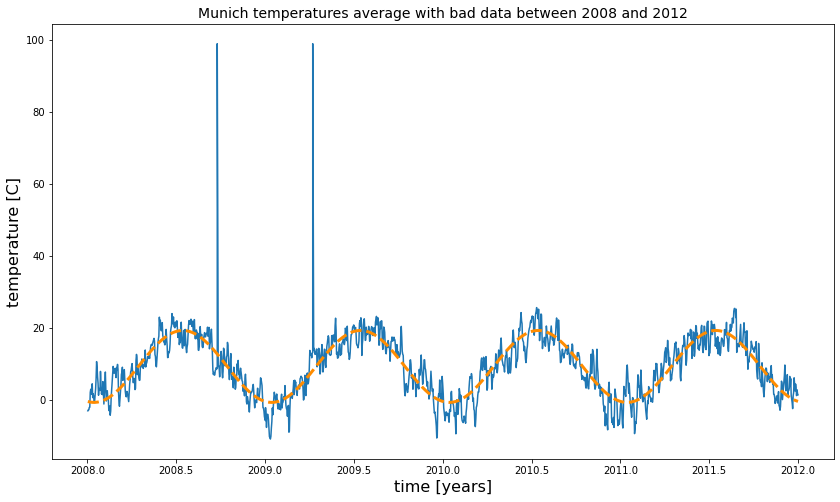


best parameters of the fit between 2008 and 2012

amplitude (temperature range):  -9.98813368108493 shift in time: -0.2333476048431593 constant background:  9.384114863029373

the average temperature in Munich between 2008 and 2012 is:  9.384097734976043

the average hottest temperature in Munich between 2008 and 2012 is:  19.372248544114303

the average coldest temperature in Munich between 2008 and 2012 is:  -0.6040188180555575

the b parameter -0.2333476048431593 is the time shift with respect to a cosine law, it represent the shift of the max temperature with respect to January,but since the phenomena 
is periodic, the max temperature is achived at 1 year + (-) this time, so at 0.7666523951568407 years, that corresponds to the 8-th month, August

3 vs 4 parameters:
CL: 0.730 , additional parameter necessary: NO


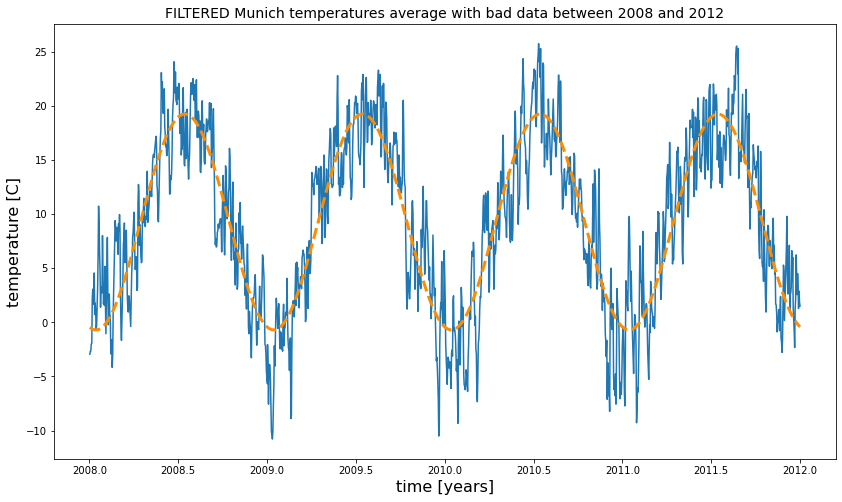

In [44]:
import pandas as pd
from scipy import optimize
import math
from scipy.stats import f

df=pd.read_table('munich_temperatures_average_with_bad_data.txt',sep=" ",header=None)
df.columns= ["time", "temp"]

time=df.iloc[:,0]
time=np.array(time)
temp=df.iloc[:,1]
temp=np.array(temp)

def f1(t, a, b, c):                              # f fit function
    return a*np.cos(2*math.pi*t+b)+c
def g(t, a, b, c, d):                              # g fit function
    return a*np.cos(2*math.pi*t*b+c)+d

fig1 = plt.figure(figsize=(14,8))   # first plot of all data
plt.plot(time, temp)
plt.xlabel('time [years]', size=16)
plt.ylabel('temperature [C]',size=16)
plt.title('Munich temperatures average with bad data (all data)', size=14)



time_short=np.linspace(min(time), max(time), len(time))
res_f, cov_f = optimize.curve_fit(f1, time, temp, p0 = [20, 20, 8])
plt.plot(time_short, f1(time_short, *res_f), 'r--', linewidth=3, color='darkorange')
plt.show()

# end of part 1 with f
# start of part 2

df2=df[(df.time > 2008) & (df.time < 2012)]     # filtering the data for the second plot
time2=df2.iloc[:,0]
time2=np.array(time2)
temp2=df2.iloc[:,1]
temp2=np.array(temp2)

fig2 = plt.figure(figsize=(14,8))    # second plot
plt.plot(time2, temp2)
plt.xlabel('time [years]', size=16)
plt.ylabel('temperature [C]',size=16)
plt.title('Munich temperatures average with bad data between 2008 and 2012', size=14)

time_short2=np.linspace(min(time2), max(time2), len(time2))
res2, cov2 = optimize.curve_fit(f1, time2, temp2, p0=[19, +0.5, -0.5])
plt.plot(time_short2, f1(time_short2, *res2), 'r--', linewidth=3, color='darkorange')
plt.show()


print('\nbest parameters of the fit between 2008 and 2012')
print('\namplitude (temperature range): ',res2[0], 'shift in time:',res2[1],'constant background: ',res2[2])
print('\nthe average temperature in Munich between 2008 and 2012 is: ', np.mean(temp2))
print('\nthe average hottest temperature in Munich between 2008 and 2012 is: ', res2[2]-res2[0])
print('\nthe average coldest temperature in Munich between 2008 and 2012 is: ', res2[2]+res2[0])
print('\nthe b parameter',res2[1],'is the time shift with respect to a cosine law, it represent the shift of the max temperature with respect to January,but since the phenomena ')
print('is periodic, the max temperature is achived at 1 year + (-) this time, so at', 1+(res2[1]), 'years, that corresponds to the 8-th month, August\n')

# end of part 2 with f
# start of part with more parameters




res_g, cov_g = optimize.curve_fit(g, time, temp, p0 = [20, 1, 20, 8])
#print(res_f)
#print(res_g)

y_f=f1(time_short, *res_f)
y_g=g(time_short, *res_g)

RSS_f=np.sum((temp-y_f)**2)
RSS_g=np.sum((temp-y_g)**2)

N=len(time)

#print(RSS_f,RSS_g)

def Ftest(ssr_1, ssr_2, ndof_1, ndof_2, nbins, verbose=False):
    F = ((ssr_1 - ssr_2)/(ndof_2 - ndof_1)) / (ssr_2/(nbins - ndof_2))
    CL = 1. - f.cdf(F, ndof_2 - ndof_1, nbins - ndof_2)
    if verbose: print("CL: %.3f" % CL, ", additional parameter necessary:", "YES" if CL < 0.10 else "NO")
    return CL


print("3 vs 4 parameters:")
cl_1_vs_2 = Ftest(RSS_f, RSS_g, 3, 4, N, verbose=True)



df2=df[(df.time > 2008) & (df.time < 2012) & (df.temp < 26)]     # filtering the data even in the temperature domain
time2=df2.iloc[:,0]
time2=np.array(time2)
temp2=df2.iloc[:,1]
temp2=np.array(temp2)

fig2 = plt.figure(figsize=(14,8))    # second plot
plt.plot(time2, temp2)
plt.xlabel('time [years]', size=16)
plt.ylabel('temperature [C]',size=16)
plt.title('FILTERED Munich temperatures average with bad data between 2008 and 2012', size=14)

time_short2=np.linspace(min(time2), max(time2), len(time2))
res2, cov2 = optimize.curve_fit(f1, time2, temp2, p0=[10, +0.5, -0.2])
plt.plot(time_short2, f1(time_short2, *res2), 'r--', linewidth=3, color='darkorange')
plt.show()